# 201013 Hierarchical clustering plotting demo

In [1]:
using ProgressMeter
using FilePathsBase; using FilePathsBase: /
using GZip
using JSON
using Mmap
using DataFrames
using CSV
using StatsBase
using CategoricalArrays
using HDF5
using Markdown
using DataStructures: counter
using AbstractTrees
using Clustering

In [2]:
using PlotlyJS
using Colors
using ColorSchemes

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5754667108675227003\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16658245782075485951\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5754667108675227003\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Revise

using Midas
using Midas.Pairwise: npairs
using Midas.ClusterAnalysis
using Midas.ClusterAnalysis: leaf_class_counts, find_strong_clusters, hclust_node_dists, makecut

using MidasPlots
using MidasPlots: Dendrogram, dgleaf_edges, ClassValues
using MidasPlots.Plotly: PlotlyDendrogram, subplot_axes, subplot_axes!, gettraces, setaxes!, vector_attrs!, class_color_strip, make_colorscale

using TriMatrices

┌ Info: Precompiling MidasPlots [1fa0408f-a5e1-472d-a139-57e7ff88ecf0]
└ @ Base loading.jl:1278


## Func defs

In [4]:
findclass(a::CategoricalArray, cls::CategoricalValue) = findall(==(cls), a)
findclass(a::CategoricalArray, i::Integer) = findclass(a, a.pool[i])
findclass(a::CategoricalArray, clss::AbstractVector{<:CategoricalValue}) = findall(∈(clss), a)
findclass(a::CategoricalArray, is::AbstractVector{<:Integer}) = findall(∈(is), a.refs)
selectclass(a::AbstractVector, c::CategoricalArray, cls) = a[findclass(c, cls)]

selectclass (generic function with 1 method)

## File paths

In [5]:
intermediate_dir = p"../../data/intermediate/200727-find-overlaps/";

In [6]:
infiles = Dict(
    :taxonomy => p"/home/jared/notebooks/midas/midas-notebooks-2019/build-v1-database/out/3-curated-taxonomy-assignments.csv",
    :distances => intermediate_dir / "genome-pw-distances.raw-float32",
    :overlaps => intermediate_dir / "200729-refseq-curated-1.1_beta-species-overlaps.h5",
);

In [7]:
outdir = p"../../data/processed/201013-overlap-clustering-analysis/201013-hclust-plotting-demo/"
mkpath(outdir)

LoadError: ../../data/processed/201013-overlap-clustering-analysis/201013-hclust-plotting-demo already exists.

## Load data

### Taxonomy

In [8]:
taxdf = DataFrame(CSV.File(infiles[:taxonomy]));

In [9]:
sig_genera = categorical(taxdf[!, :genus])
genera = levels(sig_genera)
ngenera = length(genera)

sig_species = categorical([(row[:genus], row[:species]) for row in eachrow(taxdf)])
species = levels(sig_species)
speciesnames = [join(s, " ") for s in species]
nspecies = length(species)

ngenera, nspecies

(419, 1438)

In [10]:
genus_counts = counts(sig_genera.refs)
species_counts = counts(sig_species.refs)
;

In [11]:
genome_accs = [last(split(k, "/")) for k in taxdf[!, :key]];

In [12]:
species_to_genus = [findfirst(==(genus), genera) for (genus, spname) in species];

In [13]:
nsigs = size(taxdf, 1)

50752

### Distances

In [14]:
pw_data = Mmap.mmap(open(infiles[:distances], "r"), Vector{Float32}, (npairs(nsigs),));

pw_dists = TriMatrix(TriSymmetric{false}(), nsigs, pw_data);

In [15]:
@assert !any(<(0), pw_data)

### Overlaps

In [16]:
h5open(string(infiles[:overlaps])) do h5
    @assert read(h5, "genome_keys") == taxdf[!, :key]

    global min_inter = collect(zip(read(h5, "min_inter_indices"), read(h5, "min_inter_dists")))
    global max_intra = collect(zip(read(h5, "max_intra_indices"), read(h5, "max_intra_dists")))

    global has_overlap = read(h5, "has_overlap")
    global overlap_components_vec = read(h5, "overlap_components")
end;

In [17]:
overlap_pairs = [i => min_inter[i][1] for i in has_overlap];

In [18]:
overlap_components = [findall(==(i), overlap_components_vec) for i in 1:maximum(overlap_components_vec)];

In [19]:
overlap_edges = counter(
    Int(sig_species.refs[i]) => Int(sig_species.refs[j])
    for (i, j) in overlap_pairs
);

## Component Analysis funcs

In [20]:
function activate_component(ci_::Int)
    global ci = ci_
    global comp = overlap_components[ci]
    global comp_idxs = [findclass(sig_species, c) for c in comp]
    global comp_genera = unique(g for (g, s) in species[comp])
    global singlegenus = length(comp_genera) == 1
    if singlegenus
        global comp_genus = only(comp_genera)
        global grouplabels = [s for (g, s) in species[comp]]
    else
        global comp_genus = nothing
        global groupnames = speciesnames[comp]
    end
    global component_ngenomes = sum(length.(comp_idxs))
end

activate_component (generic function with 1 method)

In [21]:
function component_species_df()
    DataFrame([(genus=species[i][1], species=species[i][2], ngenomes=species_counts[i]) for i in comp])
end

function component_edges_df()
    df = DataFrame([String, String, Int, Float64], [:A, :B, :C, :D])
    
    for ((i, j), c) in overlap_edges
        if i ∈ comp
            push!(df, (
                speciesnames[i],
                speciesnames[j],
                c,
                c / (species_counts[i] * species_counts[j])
            ))
        end
    end
    
    sort!(df, [:A, :B])
    rename!(df, ["Intra Species", "Inter Species", "Overlapping Pairs", "Overlap fraction"])
    
    return df
end

function component_summary_raw()
    buf = IOBuffer()
    
    print(buf, "### Component $ci: ")
    print(buf, join(comp_genera, ", "))
    print(buf, " (", length(comp), " species, ", sum(length.(comp_idxs)), " genomes)")
    print(buf, "\n<br>\n")
    
    sp_df = component_species_df()
    show(buf, MIME"text/html"(), sp_df, eltypes=false, summary=false)
    print(buf, "\n<br>\n")
    
    e_df = component_edges_df()
    show(buf, MIME"text/html"(), e_df, eltypes=false, summary=false)
    
    return buf
end

function component_summary(ci_=nothing)
    isnothing(ci_) || activate_component(ci_)
    
    buf = component_summary_raw()
    seek(buf, 0)
    return Markdown.parse(buf)
end

component_summary (generic function with 2 methods)

In [22]:
pal = collect(colorschemes[:tableau_20].colors)
pal = pal[vcat(1:2:17, 2:2:18)]
classcolors = ClassValues(pal, Gray(.75))

## Load component

In [23]:
component_summary(28)

### Component 28: Bifidobacterium, Chlamydia, Gardnerella, Granulicoccus, Neisseria (9 species, 1221 genomes)

<br> <table class="data-frame"><thead><tr><th></th><th>genus</th><th>species</th><th>ngenomes</th></tr></thead><tbody><tr><th>1</th><td>Bifidobacterium</td><td>pseudocatenulatum</td><td>5</td></tr><tr><th>2</th><td>Chlamydia</td><td>trachomatis</td><td>115</td></tr><tr><th>3</th><td>Gardnerella</td><td>vaginalis</td><td>42</td></tr><tr><th>4</th><td>Granulicoccus</td><td>phenolivorans</td><td>2</td></tr><tr><th>5</th><td>Neisseria</td><td>gonorrhoeae</td><td>326</td></tr><tr><th>6</th><td>Neisseria</td><td>lactamica</td><td>6</td></tr><tr><th>7</th><td>Neisseria</td><td>meningitidis</td><td>721</td></tr><tr><th>8</th><td>Neisseria</td><td>mucosa</td><td>2</td></tr><tr><th>9</th><td>Neisseria</td><td>polysaccharea</td><td>2</td></tr></tbody></table> <br> <table class="data-frame"><thead><tr><th></th><th>Intra Species</th><th>Inter Species</th><th>Overlapping Pairs</th><th>Overlap fraction</th></tr></thead><tbody><tr><th>1</th><td>Gardnerella vaginalis</td><td>Bifidobacterium pseudocatenulatum</td><td>1</td><td>0.0047619</td></tr><tr><th>2</th><td>Gardnerella vaginalis</td><td>Chlamydia trachomatis</td><td>17</td><td>0.00351967</td></tr><tr><th>3</th><td>Gardnerella vaginalis</td><td>Granulicoccus phenolivorans</td><td>2</td><td>0.0238095</td></tr><tr><th>4</th><td>Gardnerella vaginalis</td><td>Neisseria gonorrhoeae</td><td>22</td><td>0.00160678</td></tr><tr><th>5</th><td>Neisseria lactamica</td><td>Neisseria meningitidis</td><td>3</td><td>0.000693481</td></tr><tr><th>6</th><td>Neisseria lactamica</td><td>Neisseria polysaccharea</td><td>3</td><td>0.25</td></tr><tr><th>7</th><td>Neisseria meningitidis</td><td>Neisseria gonorrhoeae</td><td>714</td><td>0.0030377</td></tr><tr><th>8</th><td>Neisseria meningitidis</td><td>Neisseria lactamica</td><td>2</td><td>0.000462321</td></tr><tr><th>9</th><td>Neisseria meningitidis</td><td>Neisseria mucosa</td><td>5</td><td>0.00346741</td></tr></tbody></table>


In [24]:
comp_idxs_flat = vcat(comp_idxs...)
leaf_labels = [l for (l, n) in enumerate(species_counts[comp]) for _ in 1:n];

In [25]:
dmat = pw_dists[comp_idxs_flat, comp_idxs_flat];

In [26]:
classnames = ClassValues(speciesnames[comp], "(mixed)");

### Create tree

In [27]:
hc = hclust(dmat, linkage=:complete)
tree = HClustTree(hc)

HClustTree{Midas.ClusterAnalysis.HClustNode{Float32}} with 1221 leaves and 1220 internal nodes

In [28]:
strong_clusters = find_strong_clusters(tree, dmat);

In [29]:
node_classes = let
    cc = leaf_class_counts(tree, leaf_labels);
    
    map(collect(cc)) do (k, v)
        c, i = findmax(v)
        k => (c == sum(v) ? i : 0)
    end |> Dict
end;

merge!(node_classes, pairs(leaf_labels));

In [30]:
cut = makecut(node -> node.id ∈ strong_clusters && node_classes[node.id] != 0, tree);
length(cut)

14

In [31]:
dg = Dendrogram(tree)
dg_trunc = Dendrogram(tree, trunc=node -> node.id ∈ cut)

Dendrogram with 27 nodes and 14 leaves

## Plots

In [32]:
function big_dendrogram(dg::Dendrogram; class_colors_gap=0)
    # Y axes
    yaxes = subplot_axes!(
        [
            attr(visible=false),
            attr(rangemode=:nonnegative),
        ],
        [.1, 1.0],
        sep=0.02
    )
    
    # Dendrogram
    pdg = PlotlyDendrogram(dg, attr(yaxis="y2"))
    
    vector_attrs!(pdg.nodes_trace, pdg.node_ids) do id
        node = tree.nodes[id]
        c = node_classes[id]
        return Dict(
            :marker_size => id ∈ strong_clusters ? 8 : 4,
            :marker_color => classcolors[c],
            :text => string(id),
            :customdata => [node.count, classnames[c]],
        )
    end
    
    merge!(pdg.nodes_trace, attr(
        hovertemplate="""
        <b>%{text}</b><br>
        %{y:.3f}<br>
        %{customdata[0]} genomes<br>
        %{customdata[1]}
        <extra></extra>
        """,
    ))
    
    for (id, trace) in pdg.branch_traces
        trace[:line_color] = classcolors[node_classes[id]]
    end
    
    # Labels
    edges = dgleaf_edges(dg)
    leaf_classes = [node_classes[id] for id in dg.leaves]
    labels_t = class_color_strip(
        leaf_classes,
        classcolors,
        edges=edges,
        text=[id <= tree.n ? "Genome $id" : "Cluster $id" for id in dg.leaves],
        customdata=[[classnames[c]] for c in leaf_classes],
        hovertemplate="""
        <b>%{text}</b><br>
        %{customdata[0]}
        <extra></extra>
        """,
        xgap=class_colors_gap,
    )
    
    layout = Layout(
        xaxis=attr(
            visible=false,
        ),
        showlegend=false,
        hovermode=:closest,
    )
    setaxes!(layout, :y, yaxes)
    
    return plot(vcat(gettraces(pdg), [labels_t]), layout)
end

big_dendrogram (generic function with 1 method)

In [33]:
let
    plt = big_dendrogram(dg)
    savehtml(plt, string(outdir / "demo-dendrogram-full.html"), :embed)
end

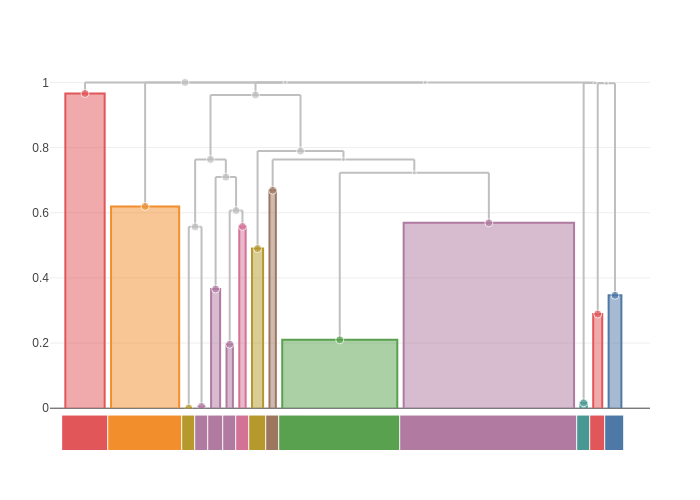

In [34]:
let
    plt = big_dendrogram(dg_trunc, class_colors_gap=1)
    savehtml(plt, string(outdir / "demo-dendrogram-truncated.html"), :embed)
    plt
end

In [35]:
function clustermap(dg; class_colors_gap=0)
    # X axes
    xaxes = subplot_axes!(
        [
            attr(
                rangemode=:nonnegative,
                autorange=:reversed,
            ),
            attr(
                visible=false,
            ),
            attr(
                visible=false,
                scaleanchor=:y,
            ),
        ],
        [.4, .05, 1.],
        sep=.01,
    )
    
    # Dendrogram
    pdg = PlotlyDendrogram(dg, attr(), horizontal=true)
    
    vector_attrs!(pdg.nodes_trace, pdg.node_ids) do id
        node = tree.nodes[id]
        c = node_classes[id]
        return Dict(
            :marker_size => id ∈ strong_clusters ? 8 : 4,
            :marker_color => classcolors[c],
            :text => string(id),
            :customdata => [node.count, classnames[c]],
        )
    end
    
    merge!(pdg.nodes_trace, attr(
        hovertemplate="""
        <b>%{text}</b><br>
        %{y:.3f}<br>
        %{customdata[0]} genomes<br>
        %{customdata[1]}
        <extra></extra>
        """,
    ))
    
    for (id, trace) in pdg.branch_traces
        trace[:line_color] = classcolors[node_classes[id]]
    end
    
    # Common
    edges = dgleaf_edges(dg)
    leaf_names = [id <= tree.n ? "Genome $id" : "Cluster $id" for id in dg.leaves]
    
    # Labels
    leaf_classes = [node_classes[i] for i in dg.leaves]
    labels_t = class_color_strip(
        leaf_classes,
        classcolors,
        edges=edges,
        vertical=true,
        text=leaf_names,
        customdata=[[classnames[c]] for c in leaf_classes],
        hovertemplate="""
        <b>%{text}</b><br>
        %{customdata[0]}
        <extra></extra>
        """,
        ygap=class_colors_gap,
        xaxis="x2",
    )
    
    # Heatmap
    hm_leaf_text = [string(n, ": ", classnames[c]) for (n, c) in zip(leaf_names, leaf_classes)]
    hm_t = heatmap(
        z=hclust_node_dists(tree, dmat, dg.leaves),
        x=edges,
        y=edges,
        customdata=[[t1, t2] for t1 in hm_leaf_text, t2 in hm_leaf_text],
        hovertemplate="""
        %{customdata[0]}<br>
        %{customdata[1]}<br>
        %{z:.3f}
        <extra></extra>
        """,
        colorscale=make_colorscale(:magma),
        xaxis="x3",
    )
    
    layout = Layout(
        yaxis=attr(
            visible=false,
        ),
        showlegend=false,
        hovermode=:closest,
        width=1000,
        height=750,
    )
    setaxes!(layout, :x, xaxes)
    
    return plot(vcat(gettraces(pdg), [hm_t, labels_t]), layout)
end

clustermap (generic function with 1 method)

In [36]:
let
    plt = clustermap(dg)
    savehtml(plt, string(outdir / "demo-clustermap-full.html"), :embed)
end

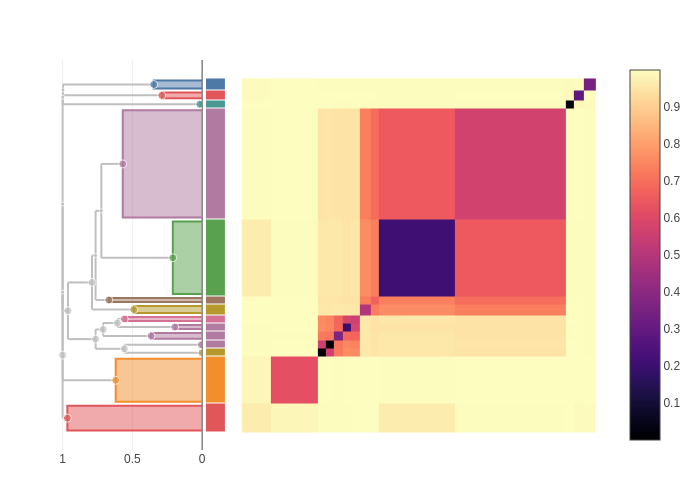

In [37]:
let
    plt = clustermap(dg_trunc, class_colors_gap=1)
    savehtml(plt, string(outdir / "demo-clustermap-truncated.html"), :embed)
    plt
end